In [7]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import sys
sys.path.insert(0,'C:\\Users\\pierr\\Documents\\code\\BayesSplicedModels')
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Exponential distribution

$X\sim\text{Exp}(\lambda)$ with pdfs

$$
f(x) = \lambda e^{-\lambda x}
$$

In [8]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Exp":
            def logp(parms):
                λ = parms[0]
                if λ > 0:
                    return(len(X) * np.log(λ) - λ * np.sum(X))
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
            
                
    def set_logps(self):
        if self.name == "Exp":
            def logp_body(X, parms,  γ):
                λ = parms[0]
                F1 = 1-np.exp(- λ * γ)
                if λ > 0 and F1 > 0:
                    return(len(X) * np.log(λ) - λ * np.sum(X) - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                λ = parms[0]
                F2 = 1-np.exp(- λ * γ)
                if λ > 0 and F2 < 1:
                    return(len(X) * np.log(λ) - λ * np.sum(X) - len(X) * np.log(1-F2))
                else:
                    return(-np.inf)
        
        self.logp_body = nb.jit(nopython = True)(logp_body)
        self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Exp":
            λ = parms[:,0]
            def logd(x):
                res = np.zeros(len(λ))
                s = λ > 0
                res[np.where(s)] = np.log(λ[s]) - λ[s] * x
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
            
    def set_logds(self):
        if self.name == "Exp":
            def logd_body(x, parms, γ):
                λ = parms[:,0]
                res = np.zeros(len(λ))
                s = np.logical_and(λ > 0, x < γ)
                res[np.where(s)] = np.log(λ[s])- λ[s] * x - np.log(1-np.exp(- λ[s] * γ[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms, γ):
                λ = parms[:,0]
                res = np.zeros(len(λ))
                s = np.logical_and(λ > 0, x > γ)
                res[np.where(s)] = np.log(λ[s]) - λ[s] * (x -  γ[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
        self.logd_body = logd_body
        self.logd_tail = logd_tail
                
    def set_cdf(self):
        if self.name == "Exp":
            def cdf(parms, x):
                λ = parms[0]
                return(1 - np.exp(- λ * x))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Exp":
            def pdf(parms, x):
                λ = parms[0]
                return(λ * np.exp(- λ * x))
        self.pdf = nb.jit(nopython = True)(pdf)
            
    def set_ppf(self):     
        if self.name == "Exp":
            def ppf(parms, y):
                λ = parms[0]
                return( -np.log(1-y) / λ )
        self.ppf = ppf
    
    def sample(self, parms, n):
        if self.name == "Exp":
            λ = parms[0]
            return(np.random.exponential(λ, size = n))
        
#     def mean(self, parms):
#         if self.name == "Exp":
#             λ = parms[0]
#             return(1/λ)
        
#     def truncated_mean(self, parms, γ):
#         if self.name == "Exp":
#             λ = parms[0]
#             return(1/λ)

## Basic checks

In [3]:
exp_dist = loss_model("Exp", ["λ"])
print(exp_dist.name, exp_dist.parm_names, exp_dist.d)
λ, x, y = np.array([1/3]), 2, 0.5
exp_dist.set_cdf(), exp_dist.set_pdf(), exp_dist.set_ppf()
exp_dist.cdf(λ, x) - st.expon().cdf(x * λ[0]), exp_dist.ppf(λ, y) - st.expon().ppf(y) / λ[0], exp_dist.pdf(λ, x) - λ[0] * st.expon().pdf(x * λ[0])

Exp ['λ'] 1


(0.0, 0.0, 0.0)

## Log likelihood checks
### Part 1

In [4]:
X, γ = exp_dist.sample(λ, 10), 2
exp_dist.set_logp(X), exp_dist.set_logps()
print(exp_dist.logp(λ) - np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0])))
print(exp_dist.logp_body(X, λ, γ) -  np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0] / st.expon().cdf(γ * λ[0]))))
print(exp_dist.logp_tail(X, λ, γ)-  np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0] / (1 - st.expon().cdf(γ * λ[0])))))

-1.7763568394002505e-15
-1.7763568394002505e-15
-1.7763568394002505e-15


### Part 2

In [5]:
X = exp_dist.sample(λ, 10)
particle_cloud = pd.DataFrame({'λ': np.array([1, 2, 1/8, 10]),
                               'γ': np.array([1, 2,4,8])})
exp_dist.set_logd(particle_cloud[['λ']].values), exp_dist.set_logds()
λ_vev, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1]
print(exp_dist.logd(X[0]) - np.log(st.expon().pdf(X[0] * λ_vev) * λ_vev) )
print(exp_dist.logd_body(X[0], particle_cloud[['λ']].values,  particle_cloud.values[:,-1]) - np.log(st.expon().pdf(X[0] * λ_vev) * λ_vev / st.expon().cdf(γ_vec * λ_vev) )  )
print(exp_dist.logd_tail(X[0], particle_cloud[['λ']].values,  particle_cloud.values[:,-1]) -  np.log(st.expon().pdf(X[0] * λ_vev) * λ_vev / (1 - st.expon().cdf(γ_vec * λ_vev))))

[0.00000000e+00 5.55111512e-17 0.00000000e+00 2.22044605e-16]
[5.55111512e-17 5.55111512e-17 2.22044605e-16 2.22044605e-16]
[-inf -inf -inf -inf]


C:\Users\pierr\AppData\Local\Temp/ipykernel_1316/3899947908.py:8: RuntimeWarning: divide by zero encountered in true_divide
  print(exp_dist.logd_tail(X[0], particle_cloud[['λ']].values,  particle_cloud.values[:,-1]) -  np.log(st.expon().pdf(X[0] * λ_vev) * λ_vev / (1 - st.expon().cdf(γ_vec * λ_vev))))


## As a single model

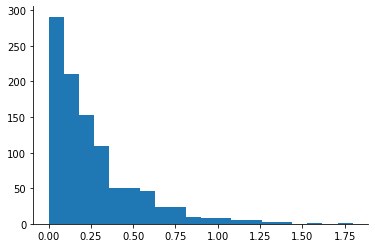

In [6]:
parms_true = np.array([4])
f = loss_model("Exp", ["λ"])
X = np.random.exponential(1/parms_true[0], size = 1000)
λ_prior = bsm.prior_model('gamma','λ', 1, 1)
prior_single_model = bsm.independent_priors([λ_prior])
plt.hist(X,bins=20)
sns.despine()

In [7]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma prior distribution
Generation: 1 ;temperature: 0.0018815994262695312 ;ESS: 999 ;steps:8 ;particle moved: 99.4%
Generation: 2 ;temperature: 0.008235669905388932 ;ESS: 999 ;steps:7 ;particle moved: 99.0%
Generation: 3 ;temperature: 0.04032478000370637 ;ESS: 1000 ;steps:7 ;particle moved: 99.5%
Generation: 4 ;temperature: 0.27561173234122255 ;ESS: 999 ;steps:6 ;particle moved: 98.75%
Generation: 5 ;temperature: 1.0 ;ESS: 1361 ;steps:7 ;particle moved: 99.6%
Wall time: 4.9 s


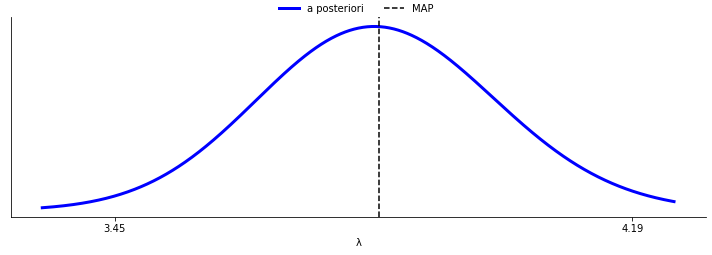

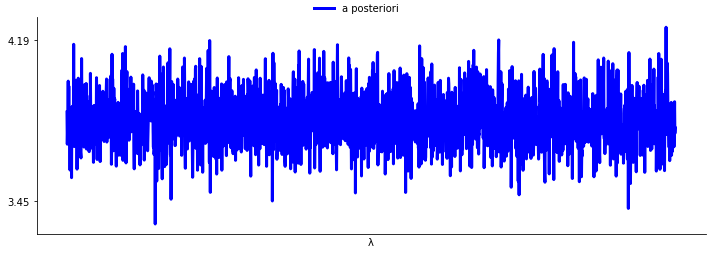

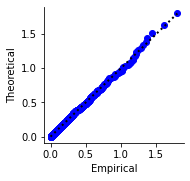

In [8]:
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
f.set_ppf()
bsm.qq_plot(X, f, trace.mean().values)

## In the composite model

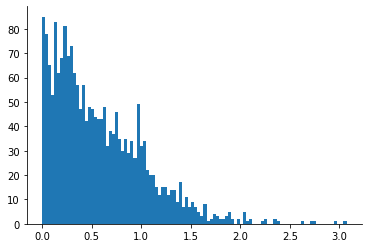

In [9]:
parms_true = np.array([1, 3, 1, 5])
f1, f2 =  loss_model("Exp", ["λ1"]), loss_model("Exp", ["α2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 2000) 
plt.hist(X,bins=100)
sns.despine()

In [10]:
λ1_prior, α2_prior, σ2_prior,  γ_prior, p_prior = bsm.prior_model('gamma','λ1', 1, 1), bsm.prior_model('gamma','α2', 1, 1),bsm.prior_model('gamma','σ2', 1, 1),  bsm.prior_model('gamma','γ', 1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([λ1_prior, α2_prior, σ2_prior,  γ_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.0022687911987304688 ;ESS: 1000 ;steps:6 ;particle moved: 99.95%
Generation: 2 ;temperature: 0.009448480663650116 ;ESS: 999 ;steps:5 ;particle moved: 100.0%
Generation: 3 ;temperature: 0.025228414120532026 ;ESS: 999 ;steps:5 ;particle moved: 99.75%
Generation: 4 ;temperature: 0.04583253679291276 ;ESS: 999 ;steps:5 ;particle moved: 99.85000000000001%
Generation: 5 ;temperature: 0.07050059864702789 ;ESS: 1000 ;steps:5 ;particle moved: 99.7%
Generation: 6 ;temperature: 0.10182025936854763 ;ESS: 1000 ;steps:5 ;particle moved: 99.75%
Generation: 7 ;temperature: 0.14202309137100966 ;ESS: 999 ;steps:5 ;particle moved: 99.9%
Generation: 8 ;temperature: 0.20020447334359648 ;ESS: 999 ;steps:5 ;particle moved: 99.8%
Generation: 9 ;temperature: 0.28888410723037855 ;ESS: 999 ;steps:5 ;particle moved: 100.0%
Generation: 10 ;temperature: 0.42235697582489085 ;ESS: 999 ;steps:5 ;particle moved: 99.9%
Ge

-836.2674772947586 1604.5345597610183 1672.6515629303642


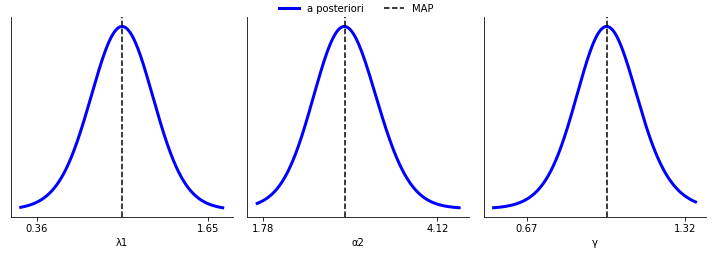

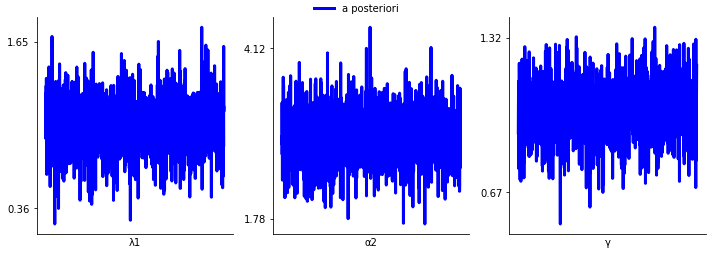

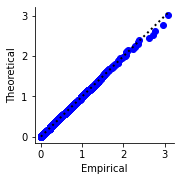

In [12]:
f.set_ppf()
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

# On the danish data set

In [14]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Exp"]
body_model_param_names = [["λ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
                [ bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1)]]

# Model for the tail of the distribution
tail_model_names = ["Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail"]
tail_model_param_names = [["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"]]

# Prior distributions over the parameters of the tail distribution
tail_model_priors= [[bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[4][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)]
]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))
for f in fs:
    f.set_ppf()
fs_dict = dict(zip(f_names, fs))

In [15]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 1min 48s


In [16]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
2,Exp-Burr-continuous,5,0.567230,-3869.680559,7631.679589,7648.065890,1.000000e+00,693.626850
0,Exp-Log-Logistic-continuous,4,0.317002,-4346.402595,8636.377839,8646.330942,9.167486e-208,2401.893835
3,Exp-Pareto-Tail-continuous,3,1.831124,-4654.730747,9271.103771,9279.562010,0.000000e+00,868.110793
1,Exp-Lomax-continuous,4,1.803594,-4657.293722,9270.490985,9280.687447,0.000000e+00,858.873058
4,Exp-GPD-Tail-continuous,4,1.822217,-4657.643261,9268.800085,9281.581134,0.000000e+00,850.557112


array([ 693.62684976, 2401.89383453,  868.1107927 ,  858.87305775,
        850.55711237])

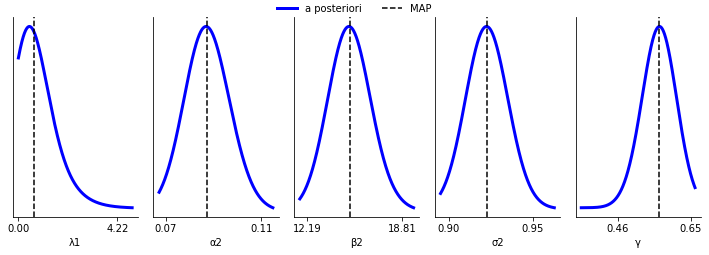

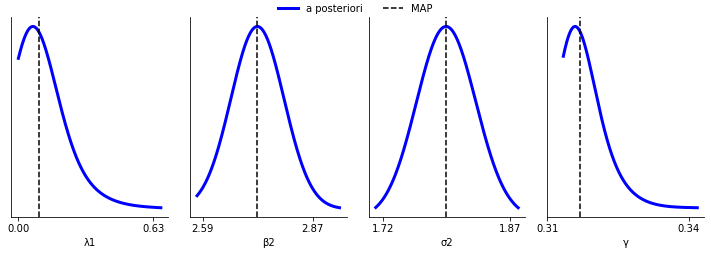

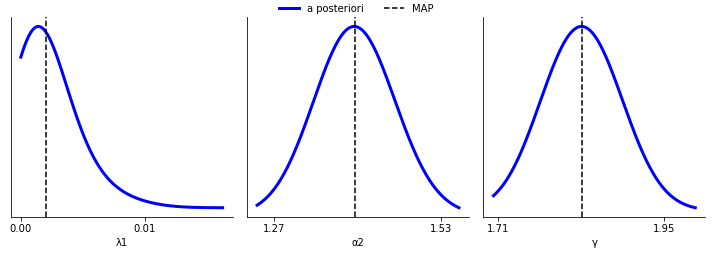

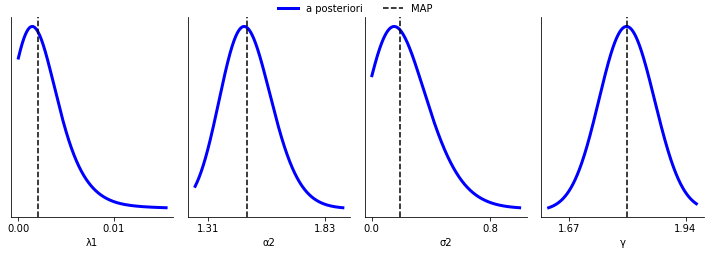

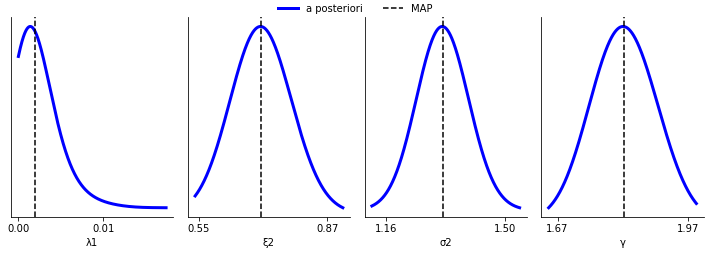

In [19]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    # bsm.qq_plot(X, f, trace.mean().values)
np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in model_names])